<a href="https://colab.research.google.com/github/pollyjuice74/5G-Decoder/blob/main/LTD_model_reg_LDPC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
!git clone https://github.com/pollyjuice74/5G-Decoder
!pip install sionna

Cloning into '5G-Decoder'...
remote: Enumerating objects: 1385, done.
remote: Counting objects: 100% (388/388), done.
remote: Compressing objects: 100% (219/219), done.
remote: Total 1385 (delta 260), reused 239 (delta 168), pack-reused 997 (from 1)
Receiving objects: 100% (1385/1385), 1.59 MiB | 1.39 MiB/s, done.
Resolving deltas: 100% (860/860), done.


In [2]:

import tensorflow as tf
import random
import numpy as np
import time
from scipy.sparse import issparse, csr_matrix

from sionna.fec.utils import generate_reg_ldpc, load_parity_check_examples, LinearEncoder, gm2pcm
from sionna.utils.plotting import PlotBER
from sionna.fec.ldpc import LDPCBPDecoder

import os
# os.chdir('../..')
if os.path.exists('5G-Decoder'):
  os.rename('5G-Decoder', '5G_Decoder')
os.chdir('5G_Decoder/adv_nn')

from dataset import *
from attention import *
from channel import *
from args import *
from model_functs import *
from models import *

Loading LDPC code
Setting n to:  100
Number of edges (VN perspective):  300
Number of edges (CN perspective):  300
Generated regular (3,6) LDPC code of length n=100
Code rate is r=0.500.


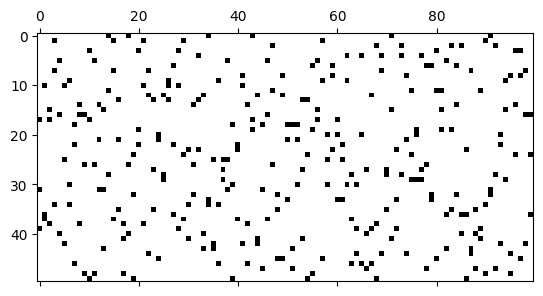

In [3]:
print("Loading LDPC code")
pcm, k, n, coderate = generate_reg_ldpc(v=3,
                                        c=6,
                                        n=100,
                                        allow_flex_len=True,
                                        verbose=True)

encoder = LinearEncoder(pcm, is_pcm=True)

In [82]:
# for e2e model
from sionna.utils import BinarySource, ebnodb2no
from sionna.mapping import Mapper, Demapper
from sionna.channel import AWGN
# from sionna.fec.ldpc import LDPC5GDecoder, LDPC5GEncoder


class Args():
    def __init__(self, model_type, code_type='LDPC', n_look_up=121, k_look_up=80, n=400, k=200,
                       n_rings=2, ls_active=True, split_diff=True, sigma=0.1,
                       t_layers=1, d_model=128, heads=8, lr=5e-4,
                       batch_size=160, batch_size_eval = 150,
                       eval_train_iter=10, save_weights_iter=100,
                       ebno_db_eval=2.5,
                       ebno_db_min=0., ebno_db_max=4., ebno_db_stepsize=0.25,
                       traindata_len=500, testdata_len=250, epochs=1000):
        assert model_type in ['gen', 'dis'], "Type must be: 'gen', Generator or 'dis', Discriminator."
        assert code_type in ['POLAR', 'BCH', 'CCSDS', 'LDPC', 'MACKAY', 'LDPC5G', 'POLAR5G'], "Invalid linear code type."


        # model data
        self.model_type = model_type

        self.split_diff = split_diff
        self.n_rings = n_rings # ring connectivity of mask
        self.sigma = sigma
        self.t_layers = t_layers
        self.ls_active = ls_active

        self.d_model = d_model
        self.heads = heads

        # training data
        self.lr = lr
        self.batch_size = batch_size
        self.traindata_len = traindata_len
        self.testdata_len = testdata_len
        self.epochs = epochs

        self.ebno_db_min = ebno_db_min
        self.ebno_db_max = ebno_db_max
        self.ebno_db_stepsize = ebno_db_stepsize

        self.ebno_db_eval = ebno_db_eval
        self.eval_train_iter = eval_train_iter
        self.save_weights_iter = save_weights_iter
        self.batch_size_eval = batch_size_eval

        # code data
        self.code_type = code_type
        self.code = self.get_code(n_look_up, k_look_up) # n,k look up values in Get_Generator_and_Parity

        # if self.code_type not in ['LDPC5G', 'POLAR5G']:
        #     self.n, self.m, self.k = self.code.n, self.code.m, self.code.k
        # else:
        #     self.n, self.m, self.k = n, n-k, k

        # self.n_steps = self.m + 5  # Number of diffusion steps

    def get_code(self, n_look_up, k_look_up):
        code = type('Code', (), {})() # class Code, no base class, no attributes/methods, () instantiate object
        # code.n_look_up, code.k_look_up = n_look_up, k_look_up
        # code.code_type = self.code_type

        # if self.code_type not in ['LDPC5G', 'POLAR5G']:
        #     G, H = Get_Generator_and_Parity(code)
        #     code.G, code.H = tf.convert_to_tensor(G), csr_matrix( tf.convert_to_tensor(H) )

        #     code.m, code.n = code.H.shape
        #     code.k = code.n - code.m

        return code


class MHAttention(Layer):
    def __init__(self, dims, heads, mask_length, linear=False, dropout=0.01):
        super().__init__()
        assert (dims % heads) == 0, 'dimension must be divisible by the number of heads'
        self.linear = linear
        self.dims = dims
        self.heads = heads
        self.dim_head = dims // heads

        if linear:
            self.k_proj = self.get_k_proj(mask_length) # n+m
            self.proj_k = None
            self.proj_v = None

        self.to_q, self.to_k, self.to_v = [ Dense(self.dims, use_bias=False) for _ in range(3) ]
        self.to_out = Dense(dims)
        self.dropout = Dropout(dropout) # to d-dimentional embeddings

    def build(self, input_shape):
        # Creates shape (n,k_proj) proj matrices for key and
        n_value = input_shape[1]
        if self.linear:
            self.proj_k = self.add_weight("proj_k", shape=[n_value, self.k_proj], initializer=GlorotUniform())
            self.proj_v = self.add_weight("proj_v", shape=[n_value, self.k_proj], initializer=GlorotUniform())

    def call(self, x, mask=None):
        out_att = self.lin_attention(x, mask) if self.linear else self.attention(x, mask)
        return out_att

    def get_k_proj(self, mask_length):
        # gets dimention for linear tranformer vector projection
        for k_proj in range(mask_length // 2, 0, -1): # starts at half the mask length TO 0
            if mask_length % k_proj == 0:
                return tf.cast(k_proj, tf.int32)

    def lin_attention(self, x, mask): # O(n)
        shape = tf.shape(x) # (b, n, d)
        b = tf.cast(shape[0], tf.int32)
        n = tf.cast(shape[1], tf.int32)

        assert x.shape[-1] is not None, "The last dimension of x is undefined."

        query, key, val = self.to_q(x), self.to_k(x), self.to_v(x)

        # Project key and val into k-dimentional space
        key = tf.einsum('bnd,nk->bkd', key, self.proj_k)
        val = tf.einsum('bnd,nk->bkd', val, self.proj_v)

        # Reshape splitting for heads
        query = tf.reshape(query, (b, n, self.heads, self.dim_head))
        key = tf.reshape(key, (b, self.k_proj, self.heads, self.dim_head))
        val = tf.reshape(val, (b, self.k_proj, self.heads, self.dim_head))
        query, key, val = [ tf.transpose(x, [0, 2, 1, 3]) for x in [query, key, val] ]

        # Low-rank mask (n,k_proj)
        mask = tf.expand_dims(mask, axis=-1)
        mask = tf.image.resize(mask, [n, self.k_proj], method='nearest')
        mask = tf.reshape(mask, (1, 1, n, self.k_proj))

        # Main attn logic: sftmx( q@k / d**0.5 ) @ v
        scores = tf.einsum('bhnd,bhkd->bhnk', query, key) / (tf.sqrt( tf.cast(self.dim_head, dtype=tf.float32) ))
        scores += (mask * -1e9) if mask is not None else 0.
        attn = tf.nn.softmax(scores, axis=-1) # (b,h,n,k_proj)
        attn = self.dropout(attn)
        out = tf.einsum('bhnk,bhkd->bhnd', attn, val)

        # Reshape and pass through out layer
        out = tf.transpose(out, [0, 2, 1, 3])
        out = tf.reshape(out, (b, n, -1))
        return self.to_out(out)

    def attention(self, x, mask): # O(n^2)
        shape = tf.shape(x)
        b = shape[0]
        n = shape[1]
        x = x[:, :, tf.newaxis] # (b,n,1)

        query, key, val = self.to_q(x), self.to_k(x), self.to_v(x) # (b, n, d)
        query, key, val = [ tf.reshape(x, (b, n, self.heads, self.dim_head)) for x in [query, key, val] ]
        query, key, val = [ tf.cast( tf.transpose(x, [0, 2, 1, 3]), tf.float32 )
                                                                            for x in [query, key, val] ]

        scores = tf.einsum('bhqd,bhkd->bhqk', query, key) / (tf.sqrt( tf.cast(self.dim_head, tf.float32) ))
        scores += (mask * -1e9) if mask is not None else 0. # apply mask non-edge connections
        attn = tf.nn.softmax(scores, axis=-1) #-1
        attn = self.dropout(attn)
        out = tf.einsum('bhqk,bhkd->bhqd', attn, val)

        out = tf.transpose(out, [0, 2, 1, 3])
        out = tf.reshape(out, (b, n, -1))
        return self.to_out(out)



class TransformerLayer(Layer):
    def __init__(self, attn, ff, norm):
        super().__init__()
        self.attn, self.ff = attn, ff
        self.norm1, self.norm2 = c(norm), c(norm)

    def call(self, x, mask):
        out = self.norm1( self.attn(x, mask) )
        return self.norm2( self.ff(out) )


class Transformer(Layer):
    def __init__(self, d_model, heads, mask, N):
        super().__init__()
        self.transformer_layers = [ TransformerLayer( MHAttention(d_model, heads, mask_length=mask.shape[0]),
                                                      FeedForward(d_model),
                                                      PreNorm() ) for _ in range(N) ]
        self.mask = mask

    def call(self, x):
        for transformer in self.transformer_layers:
            x = transformer(x, self.mask)
        return x


class TransformerDiffusion( Layer ):
    def __init__(self, args):
        super().__init__()
        self.model_type = args.model_type
        self.n_steps = args.n_steps

        code = args.code
        # assert isinstance(code.H, tf.sparse.SparseTensor), "Code's pcm must be sparse."
        self.pcm = tf.cast(code.H, dtype=tf.int32)
        # shapes
        self.m, self.n = self.pcm.shape
        self.k = self.n - self.m
        self.dims = args.d_model
        self.batch_size = args.batch_size

        self.mask = self.create_mask(self.pcm)
        # trans_call layers
        self.src_embed = tf.Variable( tf.random.uniform([1, self.n + self.m, self.dims]), trainable=True ) # (b,n+m,d)
        self.decoder = Transformer(args.d_model, args.heads, self.mask, args.t_layers) # (b,n)
        self.time_embed = Embedding(self.m//2, args.d_model)
        self.to_out = Dense(1)
        self.to_n = Dense(self.n)
        # diff layers
        self.fc = Dense(1) ###

        self.betas = tf.constant( tf.linspace(1e-3, 1e-2, args.n_steps)*0 + args.sigma )
        self.betas_bar = tf.constant( tf.math.cumsum(self.betas, 0) )

        self.split_diff = args.split_diff
        self.ls_active = args.ls_active

    def create_mask(self, H):
        m,n = H.shape
        mask = tf.eye(n+m, dtype=tf.float32) # (n+m, n+m)
        indices = tf.where(H != 0)#H.indices
        cn_con, vn_con = indices[:, 0], indices[:, 1]

        for cn, vn_i in zip(cn_con, vn_con):
            # cn to vn connections in the mask
            mask = tf.tensor_scatter_nd_update(mask, [[n+cn, vn_i],[vn_i, n+cn]], [1.0,1.0])

            # distance 2 vn neighbors of vn_i
            related_vns = vn_con[cn_con==cn]
            for vn_j in related_vns:
                mask = tf.tensor_scatter_nd_update(mask, [[vn_i, vn_j],[vn_j, vn_i]], [1.0,1.0])

        # -infinity where mask is not set
        mask = tf.cast( tf.math.logical_not(mask > 0), dtype=tf.float32) # not(mask > 0) for setting non connections to -1e9
        return mask

    def get_sigma(self, t):
        # make sure t is a positive int
        t = tf.cast( tf.abs(t), tf.int32 )
        # gather betas
        betas_t = tf.gather(self.betas, t)
        betas_bar_t = tf.gather(self.betas_bar, t)
        sigma = betas_bar_t * betas_t / (betas_bar_t + betas_t)
        return tf.cast(sigma, tf.float32)

    def get_syndrome(self, r_t):
        # Calculate syndrome (pcm @ r = 0) if r is correct in binary
        r_t = tf.reshape(r_t, (self.n, -1)) # (n,b)
        r_t_bin = tf.cast(llr_to_bin(r_t), dtype=tf.int32)
        return (self.pcm @ r_t_bin) % 2 # (m,n)@(n,b)->(m,b)

    def get_t_error(self, r_t):
        t = tf.reduce_sum( self.get_syndrome(llr_to_bin(r_t)), axis=0 ) # (m,n)@(n,b)->(m,b)->(1,b)
        t = tf.cast(tf.abs(t), dtype=tf.int32)
        return t

    # Extracts noise estimate z_hat from r
    def tran_call(self, r_t):
        # Compute synd and magn
        syndrome = tf.reshape( self.get_syndrome(r_t), (self.batch_size, self.m) ) # (m,n)@(n,b)->(m,b) check nodes
        magnitude = tf.reshape( tf.abs(r_t), (self.batch_size, self.n) ) #(n,b) variable nodes
        # make sure their the same dtype
        magnitude, syndrome = [ tf.cast(tensor, dtype=tf.float32) for tensor in [magnitude, syndrome] ]

        # Concatenate synd and magn
        nodes = tf.concat([magnitude, syndrome], axis=1)[:, :, tf.newaxis] # (b, n+m, 1)

        # Embedding nodes w/ attn and 'time' (sum syn errs) dims
        t = self.get_t_error(r_t)
        nodes_emb = self.src_embed * nodes # (b, n+m, d)
        time_emb = tf.reshape( self.time_embed(t), (self.batch_size, 1, self.dims) ) # (b,1,d)

        # Applying embeds
        emb_t = time_emb * nodes_emb # (b, n+m, d)
        logits = self.decoder(emb_t) # (b, n+m, d)

        # Converting to output shape
        emb = tf.squeeze( self.to_out(logits), axis=-1 ) # (b,n+m,d)->(b, n+m)
        z_hat = self.to_n(emb) # (b, n+m)->(b, n)
        print("z_hat: ", z_hat.shape, z_hat.dtype, t.dtype)
        return z_hat, t

    # # optimal lambda l for theoretical and for error prediction
    # def line_search(self, r_t, sigma, err_hat, lin_splits=20):
    #     l_values =  tf.reshape( tf.linspace(1., 20., lin_splits), (1, 1, lin_splits) )
    #     r_t, sigma, err_hat = [ tf.expand_dims(tensor, axis=-1) for tensor in [r_t, sigma, err_hat] ]# (n,b, 1)
    #     # print(f"sigma: {sigma}, err_hat: {err_hat}")

    #     # Compute theoretical step size w/ ls splits
    #     z_hat_values = l_values*(sigma*err_hat) # (n,b, l), l is lin_splits
    #     r_values = llr_to_bin(r_t - z_hat_values) # (n,b, l)
    #     r_values = tf.reshape(r_values, [r_values.shape[0], -1]) # (n,b*l)
    #     tf.print("r_values", r_values.shape)

    #     # sum of synds (m,n)@(n,b*l)->(m,b*l)->(b*l, 1)
    #     sum_synds = tf.reduce_sum( tf.abs( (self.pcm @ r_values) % 2 ),
    #                                axis=0 )
    #     sum_synds = tf.reshape(sum_synds, (-1, lin_splits)) # (b, l)
    #     tf.print("In linesearch Sum Syndromes: ", sum_synds)

    #     # Pick optimal ls value
    #     if self.model_type=='dis':
    #          ixs = tf.math.argmin(sum_synds, axis=1, output_type=tf.int32)[:, tf.newaxis] # (b,1) w/ ixs of optimal line search for batch b
    #     elif self.model_type=='gen':
    #          ixs = tf.math.argmax(sum_synds, axis=1, output_type=tf.int32)[:, tf.newaxis] # (b,1)
    #     # print(r_values.shape, z_hat_values.shape, ixs.shape)

    #     r_values = r_t - z_hat_values
    #     # (b, l, n) for indexing on l
    #     r_values, z_hat_values = [ tf.reshape(tensor, [-1, lin_splits, r_values.shape[0]])
    #                                         for tensor in [r_values, z_hat_values] ]

    #     # concat range of batch ixs [0,...,n-1] and optimal line search ixs for gather_nd
    #     indices = tf.concat([ tf.range(ixs.shape[0])[:, tf.newaxis], ixs ],
    #                                                         axis=-1) # (b,2)

    #     # print(r_values, z_hat_values, indices)
    #     # ix on lin_splits w/ gather_nd st. ix,(b, l, n)->(n,b)
    #     r_t1, z_hat = [ tf.reshape( tf.gather_nd(tensor, indices), (self.n, -1) )
    #                                          for tensor in [r_values, z_hat_values] ]
    #     # print(r_t1, z_hat_values)
    #     return r_t1, z_hat # r at t-1

    # def loss_fn(self, synd):
    #     return tf.reduce_mean(tf.square(synd))

    # def train_step(self, llr_ch):
    #     with tf.GradientTape() as tape:
    #         _, synd = self.tran_call(llr_ch,
    #                                  tf.reduce_sum( self.get_syndrome(llr_ch) ))
    #         loss = self.loss_fn(synd)
    #     gradients = tape.gradient(loss, self.trainable_variables)
    #     self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
    #     return loss


class Decoder( TransformerDiffusion ):
    def __init__(self, args):
        super().__init__(args)

    # 'test' function
    def call(self, r_t):
        i = tf.constant(0)  # Initialize loop counter

        def condition(r_t, i):
            # Loop while i < self.m and syndrome sum is not zero
            return tf.logical_and(i < 1, tf.reduce_sum(self.get_syndrome(r_t)) != 0) # CHANGE 5 TO SELF.M

        def body(r_t, i):
            # Perform reverse or split diffusion
            r_t = tf.cond(
                tf.logical_not(self.split_diff),
                lambda: self.split_rdiff_call(r_t),
                lambda: self.rev_diff_call(r_t),
            )
            return r_t, tf.add(i, 1)

        # Run tf.while_loop with the loop variables
        llr_hat, _ = tf.while_loop(
            condition,
            body,
            loop_vars=[r_t, i],
            maximum_iterations=self.m,
            shape_invariants=[tf.TensorShape([self.batch_size, self.n]), i.get_shape()]
        )

        return llr_hat


    # Refines recieved codeword r at time t
    def rev_diff_call(self, r_t):
        tf.print("Rev def call with line-search...")

        # Transformer error prediction
        z_hat_crude, t = self.tran_call(r_t) # (b,n)
        r_t1 = r_t - z_hat_crude*self.get_sigma(t)[:, tf.newaxis] # (b,n)
        # tf.print(r_t1)

        # # Refined estimate of the codeword for the ls diffusion step
        # r_t1, z_hat = self.line_search(r_t, sigma, err_hat) if self.ls_active else 1.
        # tf.print("After linesearch: ", r_t1)

        print("r_t1", r_t1.shape, r_t1.dtype)
        return r_t1 # r at t-1, both (b,n)

    def split_rdiff_call(self, r_t):
        tf.print("Rev diff call with split diffusion...")
        # First half-step condition subproblem
        z_hat_crude, t = self.tran_call(r_t)
        # tf.print("fc input: ", (z_hat_crude * self.get_sigma(t)[:, tf.newaxis]))
        r_t_half = r_t - 0.5 * self.fc( z_hat_crude * self.get_sigma(t)[:, tf.newaxis] )
        # tf.print("r_t_half", r_t_half)

        # Full-step diffusion subproblem
        r_t1 = r_t_half + tf.random.normal(r_t_half.shape) * tf.sqrt(self.get_sigma(t)[:, tf.newaxis])

        # Second half-step condition subproblem
        z_hat_crude_half, t = self.tran_call(r_t1)  # Reuse the second `tran_call`
        r_t1 = r_t1 - 0.5 * self.fc(z_hat_crude_half * self.get_sigma(t)[:, tf.newaxis])
        print("r_t1", r_t1.shape, r_t1.dtype)
        return r_t1  # r at t-1, both (b,n)


class E2EModel(tf.keras.Model):
    def __init__(self, encoder, decoder, k, n, return_infobits=False, es_no=False):
        super().__init__()

        self._n = n
        self._k = k

        self._binary_source = BinarySource()
        self._num_bits_per_symbol = 2
        self._mapper = Mapper("qam", self._num_bits_per_symbol)
        self._demapper = Demapper("app", "qam", self._num_bits_per_symbol)
        self._channel = AWGN()
        self._decoder = decoder
        self._encoder = encoder
        self._return_infobits = return_infobits
        self._es_no = es_no

    @tf.function(jit_compile=False)
    def call(self, batch_size, ebno_db):

        # no rate-adjustment for uncoded transmission or es_no scenario
        if self._decoder is not None and self._es_no==False:
            no = ebnodb2no(ebno_db, self._num_bits_per_symbol, self._k/self._n)
        else: #for uncoded transmissions the rate is 1
            no = ebnodb2no(ebno_db, self._num_bits_per_symbol, 1)

        b = self._binary_source([batch_size, self._k])
        if self._encoder is not None:
            c = self._encoder(b)
        else:
            c = b

        # check that rate calculations are correct
        assert self._n==c.shape[-1], "Invalid value of n."

        # zero padding to support odd codeword lengths
        if self._n%2==1:
            c_pad = tf.concat([c, tf.zeros([batch_size, 1])], axis=1)
        else: # no padding
            c_pad = c
        x = self._mapper(c_pad)

        y = self._channel([x, no])
        llr = self._demapper([y, no])

        # remove zero padded bit at the end
        if self._n%2==1:
            llr = llr[:,:-1]

        # and run the decoder
        if self._decoder is not None:
            # tf.print('llr: ', llr)
            ############################
            llr_hat = self._decoder(llr)
            ############################
            # tf.print("llr_hat: ", llr_hat)

        if self._return_infobits:
            return b, llr_hat
        else:
            return c, llr_hat


# args for decoder/discriminator
args = Args(model_type='dis')
args.code.H = pcm
args.n, args.m = pcm.shape
args.k = k
args.n_steps = args.m + 5

ltd_decoder = Decoder(args) # Linear Transformer Diffusion (LTD) Decoder

e2e_ltd = E2EModel(encoder, ltd_decoder, k, n)

In [83]:
def bin_to_llr(x):
    """ Clip llrs to 20 for numerical stability """
    llr_vector = tf.where(x == 0, -20, 20)
    return llr_vector


def train_dec(model, args):
    # loss
    loss_fn = tf.keras.losses.MeanSquaredError()
    # optimizer
    scheduler = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=args.lr, decay_steps=args.epochs) # 1000 is size of trainloader
    optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler)
    # time start
    time_start = time.time()

    # SGD update iteration
    @tf.function(jit_compile=False)
    def train_step(batch_size):
        # train for random SNRs within a pre-defined interval
        ebno_db = tf.random.uniform([batch_size, 1],
                                    minval=args.ebno_db_min,
                                    maxval=args.ebno_db_max)

        with tf.GradientTape() as tape:
            c, llr_hat = model(batch_size, ebno_db)
            # tf.print(c, llr_hat)

            llr_y = bin_to_llr(c)
            print("llr_hat", llr_hat.shape, llr_hat.dtype)
            loss_value = loss_fn(llr_y, llr_hat)

        # and apply the SGD updates
        weights = model.trainable_weights
        grads = tape.gradient(loss_value, weights) # variables
        optimizer.apply_gradients(zip(grads, weights))
        return c, llr_hat

    print("Training Linear Transformer Diffusion Model...")
    for epoch in range(1, args.epochs + 1):
        train_step(args.batch_size)

        # eval train iter
        if True:#epoch % args.eval_train_iter == 0:
            ebno_db = tf.random.uniform([args.batch_size, 1],
                                          minval=args.ebno_db_eval,
                                          maxval=args.ebno_db_eval)

            c, llr_hat = model(args.batch_size, ebno_db)

            # loss
            llr_y = bin_to_llr(c)
            loss_value = loss_fn(llr_y, llr_hat)

            # ber
            c_hat = llr_to_bin(llr_hat)
            ber = compute_ber(c, c_hat).numpy()

            # measure required time since last evaluation
            duration = time.time() - time_start # in s
            time_start = time.time() # reset counter

            print(f'Training epoch {epoch}/{args.epochs}, LR={optimizer.learning_rate.numpy():.2e}, Loss={loss_value.numpy():.5e}, BER={ber}, duration: {duration:.2f}s')

        # save weights iter
        if epoch % args.save_weights_iter == 0:
            pass

        # heat-map visualization of the model's weights
        # for var in self.trainable_variables:
        #     var_name = var.name
        #     var_value = var.numpy()

        #     # Check if the variable is at least 2D (suitable for heatmap)
        #     if len(var_value.shape) > 1:
        #         plt.figure(figsize=(8, 6))
        #         sns.heatmap(var_value, cmap='viridis')
        #         plt.title(f'Heatmap of {var_name}')
        #         plt.show()
        #     else:
        #         print(f"{var_name} has shape {var_value.shape} which is not suitable for a heatmap.")


train_dec(e2e_ltd, args)

Training Linear Transformer Diffusion Model...
z_hat:  (160, 100) <dtype: 'float32'> <dtype: 'int32'>
z_hat:  (160, 100) <dtype: 'float32'> <dtype: 'int32'>
r_t1 (160, 100) <dtype: 'float32'>
z_hat:  (160, 100) <dtype: 'float32'> <dtype: 'int32'>
r_t1 (160, 100) <dtype: 'float32'>
z_hat:  (160, 100) <dtype: 'float32'> <dtype: 'int32'>
z_hat:  (160, 100) <dtype: 'float32'> <dtype: 'int32'>
r_t1 (160, 100) <dtype: 'float32'>
z_hat:  (160, 100) <dtype: 'float32'> <dtype: 'int32'>
r_t1 (160, 100) <dtype: 'float32'>
llr_hat (160, 100) <dtype: 'float32'>


llr_hat (160, 100) <dtype: 'float32'>
Rev def call with line-search...
Rev def call with line-search...
Training epoch 1/1000, LR=5.00e-04, Loss=2.77626e+02, BER=0.0915625, duration: 11.39s
Rev def call with line-search...
Rev def call with line-search...
Training epoch 2/1000, LR=5.00e-04, Loss=2.77752e+02, BER=0.092875, duration: 0.10s
Rev def call with line-search...
Rev def call with line-search...
Training epoch 3/1000, LR=5.00e-04, Loss=2.77665e+02, BER=0.0949375, duration: 0.09s
Rev def call with line-search...
Rev def call with line-search...
Training epoch 4/1000, LR=5.00e-04, Loss=2.76734e+02, BER=0.0926875, duration: 0.08s
Rev def call with line-search...
Rev def call with line-search...
Training epoch 5/1000, LR=5.00e-04, Loss=2.76869e+02, BER=0.091875, duration: 0.08s
Rev def call with line-search...
Rev def call with line-search...
Training epoch 6/1000, LR=5.00e-04, Loss=2.77305e+02, BER=0.093375, duration: 0.07s
Rev def call with line-search...
Rev def call with line-se

KeyboardInterrupt: 